In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, RandomizedSearchCV,GridSearchCV
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings("ignore")
import math

In [145]:
data = pd.read_csv('../Data/Data_Train.csv')

In [146]:
data


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU ? BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU ? BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR ? DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR ? DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [147]:
data['Destination'].value_counts()

Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [148]:
data['Destination'].replace(['Delhi'],'New Delhi',inplace=True)

In [149]:
data['Destination'].value_counts()

Cochin       4537
Banglore     2871
New Delhi    2197
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [150]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [151]:
data[data.isna().any(axis=1)]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [152]:
data=data.dropna()

In [153]:
data["Journey_day"] = pd.to_datetime(data.Date_of_Journey, format="%d/%m/%Y").dt.day
data["Journey_month"] = pd.to_datetime(data["Date_of_Journey"], format = "%d/%m/%Y").dt.month

In [154]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3


In [155]:
data.drop(["Date_of_Journey"], axis = 1, inplace = True)

In [156]:
data["Dep_hour"] = pd.to_datetime(data["Dep_Time"]).dt.hour

# Extracting Minutes
data["Dep_min"] = pd.to_datetime(data["Dep_Time"]).dt.minute

# Now we can drop Dep_Time as it is of no use
data.drop(["Dep_Time"], axis = 1, inplace = True)

In [157]:
data.head()

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min
0,IndiGo,Banglore,New Delhi,BLR ? DEL,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,22,20
1,Air India,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,13:15,7h 25m,2 stops,No info,7662,1,5,5,50
2,Jet Airways,Delhi,Cochin,DEL ? LKO ? BOM ? COK,04:25 10 Jun,19h,2 stops,No info,13882,9,6,9,25
3,IndiGo,Kolkata,Banglore,CCU ? NAG ? BLR,23:30,5h 25m,1 stop,No info,6218,12,5,18,5
4,IndiGo,Banglore,New Delhi,BLR ? NAG ? DEL,21:35,4h 45m,1 stop,No info,13302,1,3,16,50


In [158]:
data["Arrival_hour"] = pd.to_datetime(data.Arrival_Time).dt.hour

# Extracting Minutes
data["Arrival_min"] = pd.to_datetime(data.Arrival_Time).dt.minute

# Now we can drop Arrival_Time as it is of no use
data.drop(["Arrival_Time"], axis = 1, inplace = True)

In [159]:
data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min
0,IndiGo,Banglore,New Delhi,BLR ? DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL ? LKO ? BOM ? COK,19h,2 stops,No info,13882,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU ? NAG ? BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR ? NAG ? DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35


In [160]:
from datetime import datetime

In [161]:
data['Duration'].str.split()

0        [2h, 50m]
1        [7h, 25m]
2            [19h]
3        [5h, 25m]
4        [4h, 45m]
           ...    
10678    [2h, 30m]
10679    [2h, 35m]
10680         [3h]
10681    [2h, 40m]
10682    [8h, 20m]
Name: Duration, Length: 10682, dtype: object

In [162]:
duration = list(data["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute
        else:
            duration[i] = "0h " + duration[i]           # Adds 0 hour

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1])) 

In [163]:
data["Duration_hours"] = duration_hours
data["Duration_mins"] = duration_mins

In [164]:
data

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR ? DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,7h 25m,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL ? LKO ? BOM ? COK,19h,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU ? NAG ? BLR,5h 25m,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR ? NAG ? DEL,4h 45m,1 stop,No info,13302,1,3,16,50,21,35,4,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,CCU ? BLR,2h 30m,non-stop,No info,4107,9,4,19,55,22,25,2,30
10679,Air India,Kolkata,Banglore,CCU ? BLR,2h 35m,non-stop,No info,4145,27,4,20,45,23,20,2,35
10680,Jet Airways,Banglore,New Delhi,BLR ? DEL,3h,non-stop,No info,7229,27,4,8,20,11,20,3,0
10681,Vistara,Banglore,New Delhi,BLR ? DEL,2h 40m,non-stop,No info,12648,1,3,11,30,14,10,2,40


In [165]:
data.drop(["Duration"], axis = 1, inplace = True)

In [166]:
data=pd.get_dummies(data,columns=['Airline','Source','Destination'],drop_first=True)

In [167]:
data

,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,BLR ? DEL,non-stop,No info,3897,24,3,22,20,1,10,...,0,0,0,0,0,0,0,0,0,1
1,CCU ? IXR ? BBI ? BLR,2 stops,No info,7662,1,5,5,50,13,15,...,0,0,0,0,1,0,0,0,0,0
2,DEL ? LKO ? BOM ? COK,2 stops,No info,13882,9,6,9,25,4,25,...,0,0,0,1,0,0,1,0,0,0
3,CCU ? NAG ? BLR,1 stop,No info,6218,12,5,18,5,23,30,...,0,0,0,0,1,0,0,0,0,0
4,BLR ? NAG ? DEL,1 stop,No info,13302,1,3,16,50,21,35,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,CCU ? BLR,non-stop,No info,4107,9,4,19,55,22,25,...,0,0,0,0,1,0,0,0,0,0
10679,CCU ? BLR,non-stop,No info,4145,27,4,20,45,23,20,...,0,0,0,0,1,0,0,0,0,0
10680,BLR ? DEL,non-stop,No info,7229,27,4,8,20,11,20,...,0,0,0,0,0,0,0,0,0,1
10681,BLR ? DEL,non-stop,No info,12648,1,3,11,30,14,10,...,1,0,0,0,0,0,0,0,0,1


In [168]:
data.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

In [169]:

data["Total_Stops"].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [170]:
data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

In [171]:
data

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,...,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,3897,24,3,22,20,1,10,2,50,...,0,0,0,0,0,0,0,0,0,1
1,2,7662,1,5,5,50,13,15,7,25,...,0,0,0,0,1,0,0,0,0,0
2,2,13882,9,6,9,25,4,25,19,0,...,0,0,0,1,0,0,1,0,0,0
3,1,6218,12,5,18,5,23,30,5,25,...,0,0,0,0,1,0,0,0,0,0
4,1,13302,1,3,16,50,21,35,4,45,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0,4107,9,4,19,55,22,25,2,30,...,0,0,0,0,1,0,0,0,0,0
10679,0,4145,27,4,20,45,23,20,2,35,...,0,0,0,0,1,0,0,0,0,0
10680,0,7229,27,4,8,20,11,20,3,0,...,0,0,0,0,0,0,0,0,0,1
10681,0,12648,1,3,11,30,14,10,2,40,...,1,0,0,0,0,0,0,0,0,1


In [172]:
data.columns

Index(['Total_Stops', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Hyderabad', 'Destination_Kolkata',
       'Destination_New Delhi'],
      dtype='object')

In [173]:
## Outlier Analysis
col_selected=['Total_Stops', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Duration_mins']

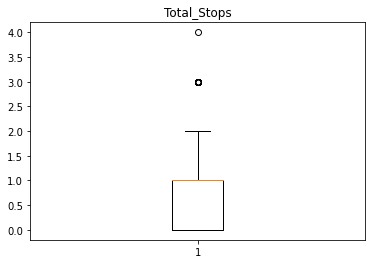

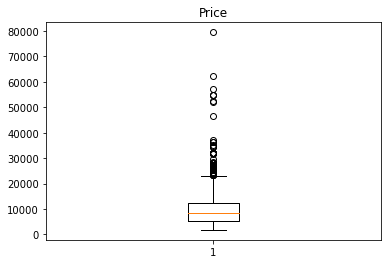

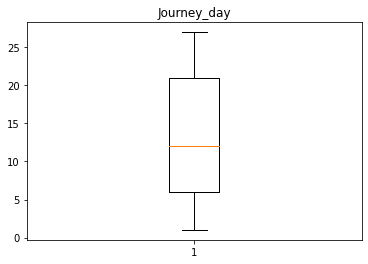

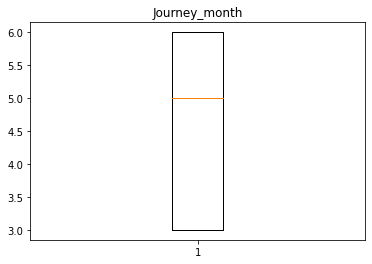

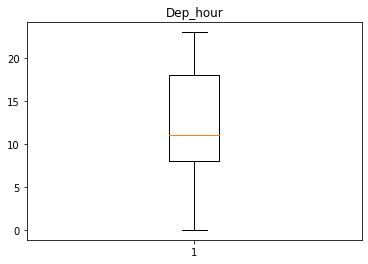

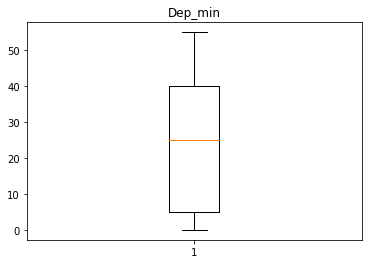

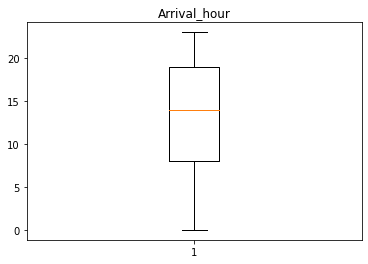

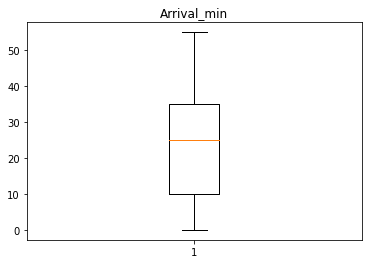

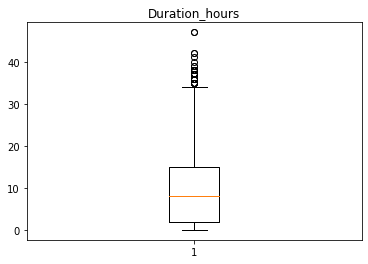

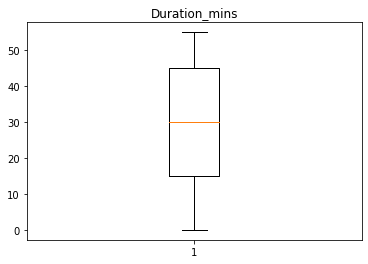

In [174]:
i = 0

for item in col_selected:
    plt.figure(i)
    plt.boxplot(data[item])
    plt.title(item)
    i+=1
## Here we can see which columns have outliers

In [175]:
# So, we have outliers in. Price,Duration_hours,Total_Stops

In [176]:
col_with_outlier=['Price','Duration_hours','Total_Stops']

In [177]:
for col in col_with_outlier:
    percentile25 = data[col].quantile(0.25)
    percentile75 = data[col].quantile(0.75)

    iqr=percentile75-percentile25

    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    
#     new_df_cap = X.copy()
    data[col] = np.where(
        data[col] > upper_limit,
        upper_limit,
        np.where(
            data[col] < lower_limit,
            lower_limit,
            data[col]
        )
    )

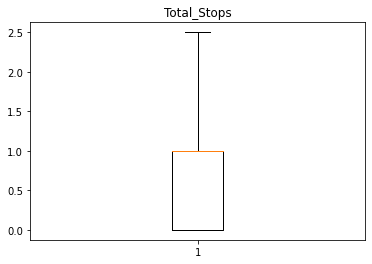

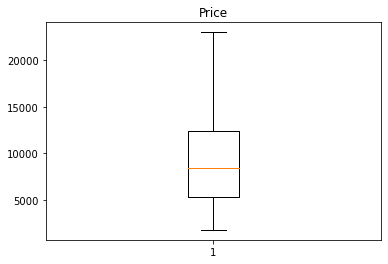

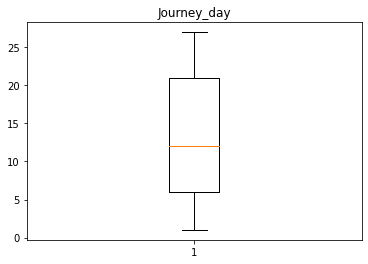

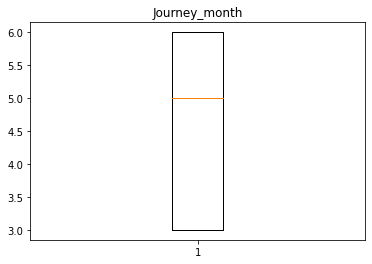

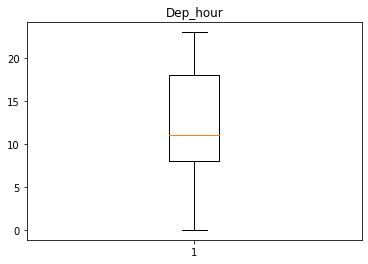

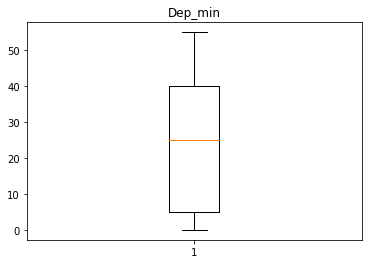

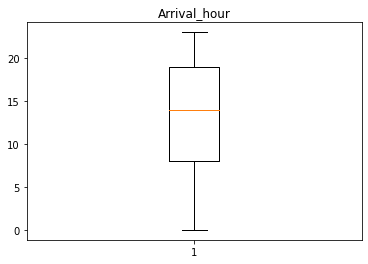

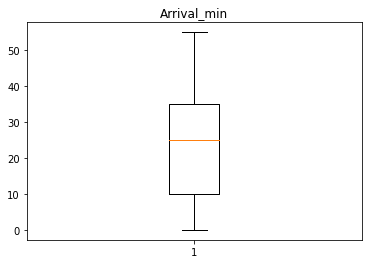

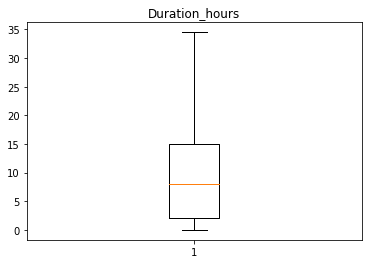

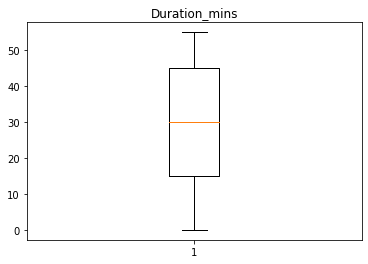

In [178]:
i = 0

for item in col_selected:
    plt.figure(i)
    plt.boxplot(data[item])
    plt.title(item)
    i+=1
## Here we can see which columns have outliers

### Applying Sin and Cos transformation

In [179]:
periodic_cols=['Journey_day','Journey_month','Dep_hour','Dep_min','Arrival_hour','Arrival_min','Duration_hours','Duration_mins']
for i in periodic_cols:
    data[i+'sin'] = np.sin(2 * np.pi * data[i]/23.0)
    data[i+'cos'] = np.cos(2 * np.pi * data[i]/23.0)

In [180]:
data

,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,...,Dep_minsin,Dep_mincos,Arrival_hoursin,Arrival_hourcos,Arrival_minsin,Arrival_mincos,Duration_hourssin,Duration_hourscos,Duration_minssin,Duration_minscos
0,0.0,3897.0,24,3,22,20,1,10,2.0,50,...,-0.730836,0.682553,2.697968e-01,0.962917,0.398401,-0.917211,0.519584,0.854419,0.887885,0.460065
1,2.0,7662.0,1,5,5,50,13,15,7.0,25,...,0.887885,0.460065,-3.984011e-01,-0.917211,-0.816970,-0.576680,0.942261,-0.334880,0.519584,0.854419
2,2.0,13882.0,9,6,9,25,4,25,19.0,0,...,0.519584,0.854419,8.878852e-01,0.460065,0.519584,0.854419,-0.887885,0.460065,0.000000,1.000000
3,1.0,6218.0,12,5,18,5,23,30,5.0,25,...,0.979084,0.203456,-2.449294e-16,1.000000,0.942261,-0.334880,0.979084,0.203456,0.519584,0.854419
4,1.0,13302.0,1,3,16,50,21,35,4.0,45,...,0.887885,0.460065,-5.195840e-01,0.854419,-0.136167,-0.990686,0.887885,0.460065,-0.269797,0.962917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0.0,4107.0,9,4,19,55,22,25,2.0,30,...,0.631088,-0.775711,-2.697968e-01,0.962917,0.519584,0.854419,0.519584,0.854419,0.942261,-0.334880
10679,0.0,4145.0,27,4,20,45,23,20,2.0,35,...,-0.269797,0.962917,-2.449294e-16,1.000000,-0.730836,0.682553,0.519584,0.854419,-0.136167,-0.990686
10680,0.0,7229.0,27,4,8,20,11,20,3.0,0,...,-0.730836,0.682553,1.361666e-01,-0.990686,-0.730836,0.682553,0.730836,0.682553,0.000000,1.000000
10681,0.0,12648.0,1,3,11,30,14,10,2.0,40,...,0.942261,-0.334880,-6.310879e-01,-0.775711,0.398401,-0.917211,0.519584,0.854419,-0.997669,-0.068242


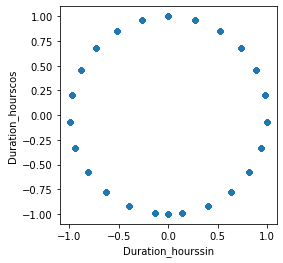

In [181]:
ax = data.plot.scatter('Duration_hourssin', 'Duration_hourscos').set_aspect('equal')

In [182]:
data=data.drop(['Journey_day','Journey_month','Dep_hour','Dep_min','Arrival_hour','Arrival_min','Duration_hours','Duration_mins'], axis=1)

In [183]:
data

,Total_Stops,Price,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,...,Dep_minsin,Dep_mincos,Arrival_hoursin,Arrival_hourcos,Arrival_minsin,Arrival_mincos,Duration_hourssin,Duration_hourscos,Duration_minssin,Duration_minscos
0,0.0,3897.0,0,0,1,0,0,0,0,0,...,-0.730836,0.682553,2.697968e-01,0.962917,0.398401,-0.917211,0.519584,0.854419,0.887885,0.460065
1,2.0,7662.0,1,0,0,0,0,0,0,0,...,0.887885,0.460065,-3.984011e-01,-0.917211,-0.816970,-0.576680,0.942261,-0.334880,0.519584,0.854419
2,2.0,13882.0,0,0,0,1,0,0,0,0,...,0.519584,0.854419,8.878852e-01,0.460065,0.519584,0.854419,-0.887885,0.460065,0.000000,1.000000
3,1.0,6218.0,0,0,1,0,0,0,0,0,...,0.979084,0.203456,-2.449294e-16,1.000000,0.942261,-0.334880,0.979084,0.203456,0.519584,0.854419
4,1.0,13302.0,0,0,1,0,0,0,0,0,...,0.887885,0.460065,-5.195840e-01,0.854419,-0.136167,-0.990686,0.887885,0.460065,-0.269797,0.962917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0.0,4107.0,0,0,0,0,0,0,0,0,...,0.631088,-0.775711,-2.697968e-01,0.962917,0.519584,0.854419,0.519584,0.854419,0.942261,-0.334880
10679,0.0,4145.0,1,0,0,0,0,0,0,0,...,-0.269797,0.962917,-2.449294e-16,1.000000,-0.730836,0.682553,0.519584,0.854419,-0.136167,-0.990686
10680,0.0,7229.0,0,0,0,1,0,0,0,0,...,-0.730836,0.682553,1.361666e-01,-0.990686,-0.730836,0.682553,0.730836,0.682553,0.000000,1.000000
10681,0.0,12648.0,0,0,0,0,0,0,0,0,...,0.942261,-0.334880,-6.310879e-01,-0.775711,0.398401,-0.917211,0.519584,0.854419,-0.997669,-0.068242


In [184]:
X=data.drop(columns=['Price'],axis=1)
y=data['Price']

In [185]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [186]:
reg_rf = RandomForestRegressor(random_state=42)
reg_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [187]:
y_pred = reg_rf.predict(X_test)

In [188]:
reg_rf.score(X_train, y_train)

0.935928918977704

In [189]:
reg_rf.score(X_test,y_test)

0.790856072307045

In [190]:
# R2_scr_cv=[]
# for model in regressors:
#     print(model)
    
#     R2_scr_cv.append(np.mean(cross_val_score(model, X, y, cv=10, scoring='r2')))

In [191]:
## Applying all models with crossvalidation 

In [192]:
regressors = [
        LinearRegression(),
        RandomForestRegressor(random_state=42),
        XGBRegressor(random_state=42),
        
        DecisionTreeRegressor(random_state=42)
            ]

In [193]:
R2_scr_cv=[]
for model in regressors:
    print(model)
    
    R2_scr_cv.append(np.mean(cross_val_score(model, X, y, cv=5, scoring='r2')))
    print(R2_scr_cv)

LinearRegression()
[-3.268445855687836e+20]
RandomForestRegressor(random_state=42)
[-3.268445855687836e+20, 0.7804854654195714]
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=42,
             reg_alpha=None, reg_lambda=None, ...)
[-3.268445855687836e+20, 0.7804854654195714, 0.8173334286238003]
DecisionTreeRegressor(random_state=42)
[-3.268445855687836e+20, 0.7804854654195

In [194]:
## Now, 2 best models till now are random forest and XG boost, So we will perform RFECV and Hyperparameter tuning on them

In [195]:
## Performing RFE on Random Forest first


selector = RFECV(RandomForestRegressor(random_state=42), step=1, cv=5)
selector = selector.fit(X, y)
selector.support_




array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [196]:
selector.n_features_

35

In [197]:
df_features = pd.DataFrame(columns = ['feature', 'support', 'ranking'])

for i in range(X.shape[1]):
    row = {'feature': i, 'support': selector.support_[i], 'ranking': selector.ranking_[i]}
    df_features = df_features.append(row, ignore_index=True)
    
df_features.sort_values(by='ranking').head()

,feature,support,ranking
0,0,True,1
20,20,True,1
21,21,True,1
22,22,True,1
23,23,True,1


In [198]:
df_features[df_features['support']==True].head()

,feature,support,ranking
0,0,True,1
1,1,True,1
2,2,True,1
3,3,True,1
4,4,True,1


In [199]:
selected_features = selector.get_support(1)
X1 = X[X.columns[selected_features]]
X1

,Total_Stops,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,...,Dep_minsin,Dep_mincos,Arrival_hoursin,Arrival_hourcos,Arrival_minsin,Arrival_mincos,Duration_hourssin,Duration_hourscos,Duration_minssin,Duration_minscos
0,0.0,0,0,1,0,0,0,0,0,0,...,-0.730836,0.682553,2.697968e-01,0.962917,0.398401,-0.917211,0.519584,0.854419,0.887885,0.460065
1,2.0,1,0,0,0,0,0,0,0,0,...,0.887885,0.460065,-3.984011e-01,-0.917211,-0.816970,-0.576680,0.942261,-0.334880,0.519584,0.854419
2,2.0,0,0,0,1,0,0,0,0,0,...,0.519584,0.854419,8.878852e-01,0.460065,0.519584,0.854419,-0.887885,0.460065,0.000000,1.000000
3,1.0,0,0,1,0,0,0,0,0,0,...,0.979084,0.203456,-2.449294e-16,1.000000,0.942261,-0.334880,0.979084,0.203456,0.519584,0.854419
4,1.0,0,0,1,0,0,0,0,0,0,...,0.887885,0.460065,-5.195840e-01,0.854419,-0.136167,-0.990686,0.887885,0.460065,-0.269797,0.962917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0.0,0,0,0,0,0,0,0,0,0,...,0.631088,-0.775711,-2.697968e-01,0.962917,0.519584,0.854419,0.519584,0.854419,0.942261,-0.334880
10679,0.0,1,0,0,0,0,0,0,0,0,...,-0.269797,0.962917,-2.449294e-16,1.000000,-0.730836,0.682553,0.519584,0.854419,-0.136167,-0.990686
10680,0.0,0,0,0,1,0,0,0,0,0,...,-0.730836,0.682553,1.361666e-01,-0.990686,-0.730836,0.682553,0.730836,0.682553,0.000000,1.000000
10681,0.0,0,0,0,0,0,0,0,0,0,...,0.942261,-0.334880,-6.310879e-01,-0.775711,0.398401,-0.917211,0.519584,0.854419,-0.997669,-0.068242


In [200]:
# #Now we will check the performance by cross validation of RF with cross validation
# print('The R square score of RF with RFE less features->>',np.mean(cross_val_score(RandomForestRegressor(random_state=42), X1, y, cv=5, scoring='r2')))
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size = 0.2, random_state = 42)
reg_rf = RandomForestRegressor(random_state=42)
reg_rf.fit(X_train, y_train)
y_pred = reg_rf.predict(X_test)
reg_rf.score(X_test,y_test)

0.7910621915182839

In [201]:
## We reduced the dimentionality ad performance is not decresed

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
reg_rf = XGBRegressor(objective ='reg:squarederror',random_state=42)
reg_rf.fit(X_train, y_train)
y_pred = reg_rf.predict(X_test)
reg_rf.score(X_test,y_test)

0.8269539349696761

In [203]:
## Here we can see that even after removing three features the performance increase a bit, Now we will check for XG bosst regressor

selector_xgb = RFECV(XGBRegressor(random_state=42), step=1, cv=5)
selector_xgb = selector_xgb.fit(X, y)
selector_xgb.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False, False,  True,  True,  True, False, False,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False])

In [204]:
# From the above array we can see that for XGB also three features are irrelevant but the features are diff ones.

In [205]:
selector_xgb.n_features_

27

In [206]:
df_features = pd.DataFrame(columns = ['feature', 'support', 'ranking'])

for i in range(X.shape[1]):
    row = {'feature': i, 'support': selector_xgb.support_[i], 'ranking': selector_xgb.ranking_[i]}
    df_features = df_features.append(row, ignore_index=True)
    
df_features.sort_values(by='ranking').head()

,feature,support,ranking
0,0,True,1
24,24,True,1
27,27,True,1
22,22,True,1
21,21,True,1


In [207]:
df_features[df_features['support']==True].head()

,feature,support,ranking
0,0,True,1
1,1,True,1
2,2,True,1
3,3,True,1
4,4,True,1


In [208]:
selected_features = selector_xgb.get_support(1)
X2 = X[X.columns[selected_features]]
X2

,Total_Stops,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Vistara,...,Dep_hoursin,Dep_hourcos,Dep_minsin,Dep_mincos,Arrival_hoursin,Arrival_hourcos,Arrival_minsin,Arrival_mincos,Duration_hourssin,Duration_hourscos
0,0.0,0,0,1,0,0,0,0,0,0,...,-0.269797,0.962917,-0.730836,0.682553,2.697968e-01,0.962917,0.398401,-0.917211,0.519584,0.854419
1,2.0,1,0,0,0,0,0,0,0,0,...,0.979084,0.203456,0.887885,0.460065,-3.984011e-01,-0.917211,-0.816970,-0.576680,0.942261,-0.334880
2,2.0,0,0,0,1,0,0,0,0,0,...,0.631088,-0.775711,0.519584,0.854419,8.878852e-01,0.460065,0.519584,0.854419,-0.887885,0.460065
3,1.0,0,0,1,0,0,0,0,0,0,...,-0.979084,0.203456,0.979084,0.203456,-2.449294e-16,1.000000,0.942261,-0.334880,0.979084,0.203456
4,1.0,0,0,1,0,0,0,0,0,0,...,-0.942261,-0.334880,0.887885,0.460065,-5.195840e-01,0.854419,-0.136167,-0.990686,0.887885,0.460065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0.0,0,0,0,0,0,0,0,0,0,...,-0.887885,0.460065,0.631088,-0.775711,-2.697968e-01,0.962917,0.519584,0.854419,0.519584,0.854419
10679,0.0,1,0,0,0,0,0,0,0,0,...,-0.730836,0.682553,-0.269797,0.962917,-2.449294e-16,1.000000,-0.730836,0.682553,0.519584,0.854419
10680,0.0,0,0,0,1,0,0,0,0,0,...,0.816970,-0.576680,-0.730836,0.682553,1.361666e-01,-0.990686,-0.730836,0.682553,0.730836,0.682553
10681,0.0,0,0,0,0,0,0,0,0,1,...,0.136167,-0.990686,0.942261,-0.334880,-6.310879e-01,-0.775711,0.398401,-0.917211,0.519584,0.854419


In [209]:
# #Now we will check the performance by cross validation of RF with cross validation
# print('The R square score of XGB with RFE less features->>',np.mean(cross_val_score(XGBRegressor(objective ='reg:squarederror',random_state=42), X2, y, cv=5, scoring='r2')))



In [210]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.2, random_state = 42)
reg_rf = XGBRegressor(objective ='reg:squarederror',random_state=42)
reg_rf.fit(X_train, y_train)
y_pred = reg_rf.predict(X_test)
reg_rf.score(X_test,y_test)

0.8299065426515058

In [211]:
## Here, from rsults above we can clearly say that after RFECV the model complexity decreases and there is not much effec t on model accuracy.

In [212]:
#Now, we will perform hyperparameter tuning

## Hyperparameter Tuning

In [213]:
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
# # Number of features to consider at every split
# criterion=['squared_error','absolute_error','poisson']
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(5, 30, num = 3)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10, 15, 25]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 3,4,5,6,10]

In [214]:
# Number of trees in random forest
n_estimators = [100,200,300]
# Number of features to consider at every split
#criterion=['squared_error','absolute_error','poisson']
#max_features = ['auto', 'sqrt']
#max_features.append(1)
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 25]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3,4]

In [215]:
random_grid = {'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_depth': max_depth,
               }

In [216]:
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size = 0.2, random_state = 42)

In [218]:
rf_random = GridSearchCV(estimator =  RandomForestRegressor(random_state=42), param_grid = random_grid,scoring='r2', cv = 5, verbose=3, n_jobs = 1)


In [219]:

rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV 1/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.684 total time=   0.7s
[CV 2/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.673 total time=   0.7s
[CV 3/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.684 total time=   0.7s
[CV 4/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.689 total time=   0.7s
[CV 5/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.661 total time=   0.7s
[CV 1/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.685 total time=   1.5s
[CV 2/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.674 total time=   1.5s
[CV 3/5] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.684 total time=   1.5s


[CV 1/5] END max_depth=5, min_samples_leaf=1, min_samples_split=25, n_estimators=300;, score=0.681 total time=   2.3s
[CV 2/5] END max_depth=5, min_samples_leaf=1, min_samples_split=25, n_estimators=300;, score=0.674 total time=   2.3s
[CV 3/5] END max_depth=5, min_samples_leaf=1, min_samples_split=25, n_estimators=300;, score=0.681 total time=   2.3s
[CV 4/5] END max_depth=5, min_samples_leaf=1, min_samples_split=25, n_estimators=300;, score=0.685 total time=   2.3s
[CV 5/5] END max_depth=5, min_samples_leaf=1, min_samples_split=25, n_estimators=300;, score=0.664 total time=   2.3s
[CV 1/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.684 total time=   0.7s
[CV 2/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.674 total time=   0.7s
[CV 3/5] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.684 total time=   0.7s
[CV 4/5] END max_depth=5, min_samples_leaf=2, min_samples_s

[CV 1/5] END max_depth=5, min_samples_leaf=2, min_samples_split=25, n_estimators=200;, score=0.682 total time=   1.5s
[CV 2/5] END max_depth=5, min_samples_leaf=2, min_samples_split=25, n_estimators=200;, score=0.675 total time=   1.5s
[CV 3/5] END max_depth=5, min_samples_leaf=2, min_samples_split=25, n_estimators=200;, score=0.681 total time=   1.5s
[CV 4/5] END max_depth=5, min_samples_leaf=2, min_samples_split=25, n_estimators=200;, score=0.686 total time=   1.5s
[CV 5/5] END max_depth=5, min_samples_leaf=2, min_samples_split=25, n_estimators=200;, score=0.662 total time=   1.5s
[CV 1/5] END max_depth=5, min_samples_leaf=2, min_samples_split=25, n_estimators=300;, score=0.681 total time=   2.3s
[CV 2/5] END max_depth=5, min_samples_leaf=2, min_samples_split=25, n_estimators=300;, score=0.674 total time=   2.3s
[CV 3/5] END max_depth=5, min_samples_leaf=2, min_samples_split=25, n_estimators=300;, score=0.681 total time=   2.4s
[CV 4/5] END max_depth=5, min_samples_leaf=2, min_sample

[CV 1/5] END max_depth=5, min_samples_leaf=3, min_samples_split=25, n_estimators=100;, score=0.681 total time=   0.7s
[CV 2/5] END max_depth=5, min_samples_leaf=3, min_samples_split=25, n_estimators=100;, score=0.675 total time=   0.7s
[CV 3/5] END max_depth=5, min_samples_leaf=3, min_samples_split=25, n_estimators=100;, score=0.682 total time=   0.7s
[CV 4/5] END max_depth=5, min_samples_leaf=3, min_samples_split=25, n_estimators=100;, score=0.687 total time=   0.7s
[CV 5/5] END max_depth=5, min_samples_leaf=3, min_samples_split=25, n_estimators=100;, score=0.660 total time=   0.7s
[CV 1/5] END max_depth=5, min_samples_leaf=3, min_samples_split=25, n_estimators=200;, score=0.682 total time=   1.5s
[CV 2/5] END max_depth=5, min_samples_leaf=3, min_samples_split=25, n_estimators=200;, score=0.675 total time=   1.5s
[CV 3/5] END max_depth=5, min_samples_leaf=3, min_samples_split=25, n_estimators=200;, score=0.682 total time=   1.5s
[CV 4/5] END max_depth=5, min_samples_leaf=3, min_sample

[CV 1/5] END max_depth=5, min_samples_leaf=4, min_samples_split=15, n_estimators=300;, score=0.684 total time=   2.3s
[CV 2/5] END max_depth=5, min_samples_leaf=4, min_samples_split=15, n_estimators=300;, score=0.675 total time=   2.3s
[CV 3/5] END max_depth=5, min_samples_leaf=4, min_samples_split=15, n_estimators=300;, score=0.684 total time=   2.3s
[CV 4/5] END max_depth=5, min_samples_leaf=4, min_samples_split=15, n_estimators=300;, score=0.688 total time=   2.3s
[CV 5/5] END max_depth=5, min_samples_leaf=4, min_samples_split=15, n_estimators=300;, score=0.664 total time=   2.3s
[CV 1/5] END max_depth=5, min_samples_leaf=4, min_samples_split=25, n_estimators=100;, score=0.681 total time=   0.7s
[CV 2/5] END max_depth=5, min_samples_leaf=4, min_samples_split=25, n_estimators=100;, score=0.674 total time=   0.7s
[CV 3/5] END max_depth=5, min_samples_leaf=4, min_samples_split=25, n_estimators=100;, score=0.682 total time=   0.7s
[CV 4/5] END max_depth=5, min_samples_leaf=4, min_sample

[CV 1/5] END max_depth=17, min_samples_leaf=1, min_samples_split=15, n_estimators=200;, score=0.813 total time=   3.3s
[CV 2/5] END max_depth=17, min_samples_leaf=1, min_samples_split=15, n_estimators=200;, score=0.810 total time=   3.2s
[CV 3/5] END max_depth=17, min_samples_leaf=1, min_samples_split=15, n_estimators=200;, score=0.812 total time=   3.1s
[CV 4/5] END max_depth=17, min_samples_leaf=1, min_samples_split=15, n_estimators=200;, score=0.799 total time=   3.2s
[CV 5/5] END max_depth=17, min_samples_leaf=1, min_samples_split=15, n_estimators=200;, score=0.807 total time=   3.2s
[CV 1/5] END max_depth=17, min_samples_leaf=1, min_samples_split=15, n_estimators=300;, score=0.813 total time=   4.9s
[CV 2/5] END max_depth=17, min_samples_leaf=1, min_samples_split=15, n_estimators=300;, score=0.811 total time=   4.9s
[CV 3/5] END max_depth=17, min_samples_leaf=1, min_samples_split=15, n_estimators=300;, score=0.812 total time=   4.8s
[CV 4/5] END max_depth=17, min_samples_leaf=1, m

[CV 1/5] END max_depth=17, min_samples_leaf=2, min_samples_split=15, n_estimators=100;, score=0.815 total time=   1.5s
[CV 2/5] END max_depth=17, min_samples_leaf=2, min_samples_split=15, n_estimators=100;, score=0.806 total time=   1.5s
[CV 3/5] END max_depth=17, min_samples_leaf=2, min_samples_split=15, n_estimators=100;, score=0.812 total time=   1.5s
[CV 4/5] END max_depth=17, min_samples_leaf=2, min_samples_split=15, n_estimators=100;, score=0.799 total time=   1.5s
[CV 5/5] END max_depth=17, min_samples_leaf=2, min_samples_split=15, n_estimators=100;, score=0.807 total time=   1.5s
[CV 1/5] END max_depth=17, min_samples_leaf=2, min_samples_split=15, n_estimators=200;, score=0.815 total time=   3.1s
[CV 2/5] END max_depth=17, min_samples_leaf=2, min_samples_split=15, n_estimators=200;, score=0.808 total time=   3.1s
[CV 3/5] END max_depth=17, min_samples_leaf=2, min_samples_split=15, n_estimators=200;, score=0.812 total time=   3.0s
[CV 4/5] END max_depth=17, min_samples_leaf=2, m

[CV 1/5] END max_depth=17, min_samples_leaf=3, min_samples_split=10, n_estimators=300;, score=0.813 total time=   4.9s
[CV 2/5] END max_depth=17, min_samples_leaf=3, min_samples_split=10, n_estimators=300;, score=0.807 total time=   4.9s
[CV 3/5] END max_depth=17, min_samples_leaf=3, min_samples_split=10, n_estimators=300;, score=0.809 total time=   4.9s
[CV 4/5] END max_depth=17, min_samples_leaf=3, min_samples_split=10, n_estimators=300;, score=0.795 total time=   4.8s
[CV 5/5] END max_depth=17, min_samples_leaf=3, min_samples_split=10, n_estimators=300;, score=0.804 total time=   4.9s
[CV 1/5] END max_depth=17, min_samples_leaf=3, min_samples_split=15, n_estimators=100;, score=0.816 total time=   1.5s
[CV 2/5] END max_depth=17, min_samples_leaf=3, min_samples_split=15, n_estimators=100;, score=0.805 total time=   1.5s
[CV 3/5] END max_depth=17, min_samples_leaf=3, min_samples_split=15, n_estimators=100;, score=0.810 total time=   1.5s
[CV 4/5] END max_depth=17, min_samples_leaf=3, m

[CV 1/5] END max_depth=17, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.813 total time=   3.1s
[CV 2/5] END max_depth=17, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.804 total time=   3.1s
[CV 3/5] END max_depth=17, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.808 total time=   3.1s
[CV 4/5] END max_depth=17, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.795 total time=   3.1s
[CV 5/5] END max_depth=17, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.805 total time=   3.1s
[CV 1/5] END max_depth=17, min_samples_leaf=4, min_samples_split=10, n_estimators=300;, score=0.813 total time=   4.8s
[CV 2/5] END max_depth=17, min_samples_leaf=4, min_samples_split=10, n_estimators=300;, score=0.804 total time=   4.7s
[CV 3/5] END max_depth=17, min_samples_leaf=4, min_samples_split=10, n_estimators=300;, score=0.809 total time=   4.7s
[CV 4/5] END max_depth=17, min_samples_leaf=4, m

[CV 1/5] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.807 total time=   1.6s
[CV 2/5] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.805 total time=   1.6s
[CV 3/5] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.809 total time=   1.6s
[CV 4/5] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.795 total time=   1.6s
[CV 5/5] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=0.804 total time=   1.6s
[CV 1/5] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.809 total time=   3.4s
[CV 2/5] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.808 total time=   3.3s
[CV 3/5] END max_depth=30, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.808 total time=   3.3s
[CV 4/5] END max_depth=30, min_samples_leaf=1, m

[CV 1/5] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=0.802 total time=   5.4s
[CV 2/5] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=0.799 total time=   5.9s
[CV 3/5] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=0.802 total time=   5.6s
[CV 4/5] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=0.787 total time=   5.6s
[CV 5/5] END max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=0.795 total time=   5.7s
[CV 1/5] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.810 total time=   1.7s
[CV 2/5] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.804 total time=   1.6s
[CV 3/5] END max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.809 total time=   1.6s
[CV 4/5] END max_depth=30, min_samples_leaf=2, min_sa

[CV 1/5] END max_depth=30, min_samples_leaf=3, min_samples_split=5, n_estimators=200;, score=0.808 total time=   3.6s
[CV 2/5] END max_depth=30, min_samples_leaf=3, min_samples_split=5, n_estimators=200;, score=0.801 total time=   3.6s
[CV 3/5] END max_depth=30, min_samples_leaf=3, min_samples_split=5, n_estimators=200;, score=0.806 total time=   3.6s
[CV 4/5] END max_depth=30, min_samples_leaf=3, min_samples_split=5, n_estimators=200;, score=0.791 total time=   3.6s
[CV 5/5] END max_depth=30, min_samples_leaf=3, min_samples_split=5, n_estimators=200;, score=0.801 total time=   3.6s
[CV 1/5] END max_depth=30, min_samples_leaf=3, min_samples_split=5, n_estimators=300;, score=0.807 total time=   5.6s
[CV 2/5] END max_depth=30, min_samples_leaf=3, min_samples_split=5, n_estimators=300;, score=0.802 total time=   5.5s
[CV 3/5] END max_depth=30, min_samples_leaf=3, min_samples_split=5, n_estimators=300;, score=0.806 total time=   5.5s
[CV 4/5] END max_depth=30, min_samples_leaf=3, min_sampl

[CV 1/5] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.812 total time=   1.6s
[CV 2/5] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.803 total time=   1.6s
[CV 3/5] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.807 total time=   1.6s
[CV 4/5] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.795 total time=   1.6s
[CV 5/5] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.803 total time=   1.6s
[CV 1/5] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.812 total time=   3.4s
[CV 2/5] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.803 total time=   3.4s
[CV 3/5] END max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.807 total time=   3.3s
[CV 4/5] END max_depth=30, min_samples_leaf=4, min_sampl

[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.779 total time=   4.2s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.783 total time=   6.4s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.781 total time=   6.4s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.786 total time=   6.3s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.768 total time=   6.3s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=0.779 total time=   6.3s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.795 total time=   1.9s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100;, score=0.794 total time=   1.9s
[CV 3/5] END max_depth=None, min_samples

[CV 3/5] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.799 total time=   1.8s
[CV 4/5] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.785 total time=   1.9s
[CV 5/5] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=0.793 total time=   1.9s
[CV 1/5] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.800 total time=   3.9s
[CV 2/5] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.795 total time=   3.8s
[CV 3/5] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.799 total time=   3.8s
[CV 4/5] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.784 total time=   3.8s
[CV 5/5] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.793 total time=   3.8s
[CV 1/5] END max_depth=None, min_samples

[CV 1/5] END max_depth=None, min_samples_leaf=2, min_samples_split=25, n_estimators=300;, score=0.808 total time=   4.5s
[CV 2/5] END max_depth=None, min_samples_leaf=2, min_samples_split=25, n_estimators=300;, score=0.804 total time=   4.6s
[CV 3/5] END max_depth=None, min_samples_leaf=2, min_samples_split=25, n_estimators=300;, score=0.810 total time=   4.5s
[CV 4/5] END max_depth=None, min_samples_leaf=2, min_samples_split=25, n_estimators=300;, score=0.794 total time=   4.6s
[CV 5/5] END max_depth=None, min_samples_leaf=2, min_samples_split=25, n_estimators=300;, score=0.805 total time=   4.6s
[CV 1/5] END max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=0.807 total time=   1.7s
[CV 2/5] END max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=0.800 total time=   1.8s
[CV 3/5] END max_depth=None, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=0.805 total time=   1.7s
[CV 4/5] END max_depth=None, min_sa

[CV 4/5] END max_depth=None, min_samples_leaf=3, min_samples_split=25, n_estimators=100;, score=0.795 total time=   1.4s
[CV 5/5] END max_depth=None, min_samples_leaf=3, min_samples_split=25, n_estimators=100;, score=0.804 total time=   1.4s
[CV 1/5] END max_depth=None, min_samples_leaf=3, min_samples_split=25, n_estimators=200;, score=0.809 total time=   2.9s
[CV 2/5] END max_depth=None, min_samples_leaf=3, min_samples_split=25, n_estimators=200;, score=0.802 total time=   3.0s
[CV 3/5] END max_depth=None, min_samples_leaf=3, min_samples_split=25, n_estimators=200;, score=0.807 total time=   2.9s
[CV 4/5] END max_depth=None, min_samples_leaf=3, min_samples_split=25, n_estimators=200;, score=0.793 total time=   3.0s
[CV 5/5] END max_depth=None, min_samples_leaf=3, min_samples_split=25, n_estimators=200;, score=0.804 total time=   3.0s
[CV 1/5] END max_depth=None, min_samples_leaf=3, min_samples_split=25, n_estimators=300;, score=0.808 total time=   4.6s
[CV 2/5] END max_depth=None, min

[CV 2/5] END max_depth=None, min_samples_leaf=4, min_samples_split=15, n_estimators=300;, score=0.804 total time=   4.8s
[CV 3/5] END max_depth=None, min_samples_leaf=4, min_samples_split=15, n_estimators=300;, score=0.809 total time=   4.8s
[CV 4/5] END max_depth=None, min_samples_leaf=4, min_samples_split=15, n_estimators=300;, score=0.797 total time=   4.8s
[CV 5/5] END max_depth=None, min_samples_leaf=4, min_samples_split=15, n_estimators=300;, score=0.805 total time=   4.8s
[CV 1/5] END max_depth=None, min_samples_leaf=4, min_samples_split=25, n_estimators=100;, score=0.809 total time=   1.4s
[CV 2/5] END max_depth=None, min_samples_leaf=4, min_samples_split=25, n_estimators=100;, score=0.799 total time=   1.4s
[CV 3/5] END max_depth=None, min_samples_leaf=4, min_samples_split=25, n_estimators=100;, score=0.807 total time=   1.4s
[CV 4/5] END max_depth=None, min_samples_leaf=4, min_samples_split=25, n_estimators=100;, score=0.795 total time=   1.4s
[CV 5/5] END max_depth=None, min

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=1,
             param_grid={'max_depth': [5, 17, 30, None],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 5, 10, 15, 25],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=3)

In [220]:
mod=rf_random.best_estimator_
mod

RandomForestRegressor(min_samples_split=15, n_estimators=300, random_state=42)

In [221]:
mod.score(X_test,y_test)

0.8174271364499063

In [222]:
##### Hyperperameter tuning for XGB

In [223]:
# params = { 'max_depth': [3, 5, 6, 10, 15, 20],
#            'learning_rate': [0.01, 0.1, 0.2, 0.3],
#            'subsample': np.arange(0.5, 1.0, 0.1),
#            'colsample_bytree': np.arange(0.4, 1.0, 0.1),
#            'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
#            'n_estimators': [100, 500, 1000]}

In [224]:
params = { 'max_depth': [3, 5, 6],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
             
           'n_estimators': [100,200, 300]}

In [225]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.2, random_state = 42)

In [226]:
xgbreg = XGBRegressor(objective ='reg:squarederror',random_state=42)
reg = GridSearchCV(estimator=xgbreg,param_grid=params,scoring='r2', cv=5,n_jobs=1,verbose=3)

In [227]:
# xgbclf = XGBRegressor(objective ='reg:squarederror',random_state=42)
# clf = RandomizedSearchCV(estimator=xgbclf,
#                              param_distributions=params,
#                              scoring='accuracy',
#                              n_iter=25,
#                              n_jobs=4,
#                              verbose=3)

In [228]:
reg.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-0.040 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-0.093 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-0.104 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-0.100 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-0.156 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.556 total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.534 total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.518 total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.533 total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=200;, scor

[CV 1/5] END learning_rate=0.1, max_depth=6, n_estimators=300;, score=0.828 total time=   0.4s
[CV 2/5] END learning_rate=0.1, max_depth=6, n_estimators=300;, score=0.805 total time=   0.4s
[CV 3/5] END learning_rate=0.1, max_depth=6, n_estimators=300;, score=0.808 total time=   0.4s
[CV 4/5] END learning_rate=0.1, max_depth=6, n_estimators=300;, score=0.822 total time=   0.4s
[CV 5/5] END learning_rate=0.1, max_depth=6, n_estimators=300;, score=0.813 total time=   0.4s
[CV 1/5] END learning_rate=0.2, max_depth=3, n_estimators=100;, score=0.779 total time=   0.0s
[CV 2/5] END learning_rate=0.2, max_depth=3, n_estimators=100;, score=0.769 total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=3, n_estimators=100;, score=0.755 total time=   0.0s
[CV 4/5] END learning_rate=0.2, max_depth=3, n_estimators=100;, score=0.777 total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=3, n_estimators=100;, score=0.760 total time=   0.0s
[CV 1/5] END learning_rate=0.2, max_depth=3, n_est

[CV 3/5] END learning_rate=0.3, max_depth=6, n_estimators=200;, score=0.786 total time=   0.4s
[CV 4/5] END learning_rate=0.3, max_depth=6, n_estimators=200;, score=0.797 total time=   0.4s
[CV 5/5] END learning_rate=0.3, max_depth=6, n_estimators=200;, score=0.787 total time=   0.2s
[CV 1/5] END learning_rate=0.3, max_depth=6, n_estimators=300;, score=0.790 total time=   0.4s
[CV 2/5] END learning_rate=0.3, max_depth=6, n_estimators=300;, score=0.765 total time=   0.4s
[CV 3/5] END learning_rate=0.3, max_depth=6, n_estimators=300;, score=0.775 total time=   0.4s
[CV 4/5] END learning_rate=0.3, max_depth=6, n_estimators=300;, score=0.781 total time=   0.4s
[CV 5/5] END learning_rate=0.3, max_depth=6, n_estimators=300;, score=0.773 total time=   0.4s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat..._step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.3],
                         'max_depth': [3, 5, 6],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=3)

In [229]:
mod1=reg.best_estimator_
mod1

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [230]:
mod1.score(X_test,y_test)

0.8362636551906163

In [235]:
import pickle
# open a file, where you ant to store the data
file = open('flight_xgb.pkl', 'wb')

# dump information to that file
pickle.dump(mod1, file)